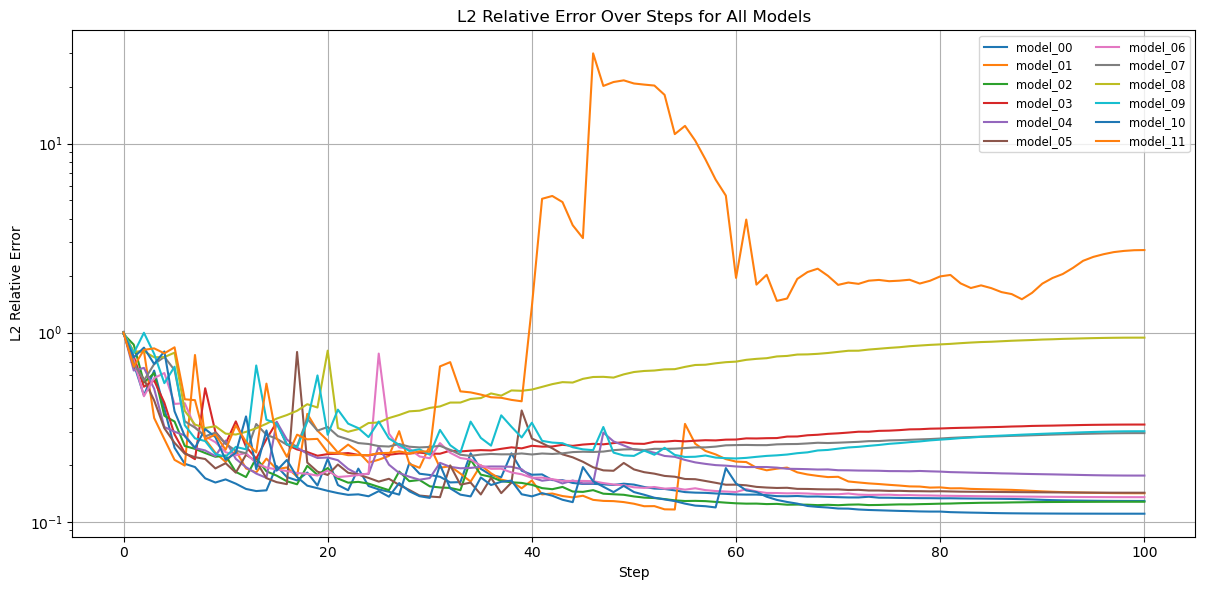

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd

base_dir = "/home/users/jbi/Bachelorarbeit/Codebase/Netze/MIONet/gauss_P_v_IC_nl_models/Parameterstudien_vvar/P_v_IC_lin_V2"
file_name = "l2_relative_error.csv"

plt.figure(figsize=(12, 6))

for i in range(12):
    model_dir = os.path.join(base_dir, f"model_{i:02d}")
    file_path = os.path.join(model_dir, file_name)

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    try:
        df = pd.read_csv(file_path, header=None)

        if df.empty or df.shape[1] < 1:
            print(f"Empty or malformed: {file_path}")
            continue

        y = df.iloc[:, 0]
        x = range(len(y))  # index as x-axis
        plt.plot(x, y, label=f"model_{i:02d}")

    except Exception as e:
        print(f"Could not read {file_path}: {e}")

plt.xlabel("Step")
plt.ylabel("L2 Relative Error")
plt.title("L2 Relative Error Over Steps for All Models")
plt.legend(fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.yscale("log")
plt.show()


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# --- Paths ---
param_csv_path = f"{base_dir}/train_results.csv"

# --- Load model parameters ---
param_df = pd.read_csv(param_csv_path)

# Extract model name from directory
param_df["model_id"] = param_df["directory"].apply(
    lambda path: os.path.basename(os.path.dirname(path))
)

# --- Collect error statistics ---
results = {}

for i in range(26):
    model_name = f"model_{i:02d}"
    file_path = os.path.join(base_dir, model_name, file_name)

    if not os.path.exists(file_path):
        continue

    try:
        df = pd.read_csv(file_path, header=None)

        if df.empty or df.shape[1] < 1:
            continue

        errors = df.iloc[:, 0]
        min_val = errors.min()
        min_idx = errors.idxmin()
        final_val = errors.iloc[-1]

        # Determine closest decade steps around the minimum
        lower_decade = (min_idx // 10) * 10
        upper_decade = lower_decade + 10
        val_lower = errors[lower_decade] if lower_decade < len(errors) else None
        val_upper = errors[upper_decade] if upper_decade < len(errors) else None

        # Get model params
        param_row = param_df[param_df["model_id"] == model_name]
        params = param_row.iloc[0].to_dict() if not param_row.empty else {}

        results[model_name] = {
            "min_error": min_val,
            "min_step": min_idx,
            "decade_steps": (lower_decade, upper_decade),
            "val_lower": val_lower,
            "val_upper": val_upper,
            "final_error": final_val,
            "params": params
        }

    except Exception as e:
        print(f"Could not read {file_path}: {e}")

# --- Sort and print top 5 models ---
top_5 = sorted(results.items(), key=lambda x: x[1]["min_error"])[:5]

print("\nTop 5 Models by Minimum L2 Relative Error with Closest Decade Steps:")
print("=" * 120)

for model_name, data in top_5:
    p = data["params"]
    low, up = data["decade_steps"]
    print(f"\n📦 {model_name}")
    print(f"  - Minimum Error       : {data['min_error']:.6e} at step {data['min_step']}")
    print(f"  - Error @ Step {low:<3} : {data['val_lower']:.6e}" if data['val_lower'] is not None else f"  - Error @ Step {low:<3} : N/A")
    print(f"  - Error @ Step {up:<3} : {data['val_upper']:.6e}" if data['val_upper'] is not None else f"  - Error @ Step {up:<3} : N/A")
    print(f"  - Final Error         : {data['final_error']:.6e}")
    print(f"  - Training Time [h]   : {p.get('train_time_h', 'N/A')}")
    #print(f"  - Final Train Loss    : {p.get('final_loss_train', 'N/A')}")
    #print(f"  - Final Test Loss     : {p.get('final_loss_test', 'N/A')}")
    print("  - Parameters:")
    print(f"    n_train             : {p.get('n_train')}")
    #print(f"    iterations          : {p.get('iterations')}")
    print(f"    neurons             : {p.get('neurons')}")
    #print(f"    layers              : {p.get('layers')}")
    print(f"    Activation IC       : {p.get('activation IC')}")
    print(f"    Activation Branch   : {p.get('activation Branch')}")
    print(f"    Activation Trunk    : {p.get('activation Trunk')}")
    #print(f"    Merge Op            : {p.get('merge_operation')}")
    #print(f"    Output Merge Op     : {p.get('output_merge_operation')}")
    #print(f"    Decay               : {p.get('decay')}")
    print("-" * 120)



Top 5 Models by Minimum L2 Relative Error with Closest Decade Steps:

📦 model_10
  - Minimum Error       : 1.103200e-01 at step 100
  - Error @ Step 100 : 1.103200e-01
  - Error @ Step 110 : N/A
  - Final Error         : 1.103200e-01
  - Training Time [h]   : 2.08
  - Parameters:
    n_train             : 8000
    neurons             : 300
    Activation IC       : swish
    Activation Branch   : relu
    Activation Trunk    : relu
------------------------------------------------------------------------------------------------------------------------

📦 model_01
  - Minimum Error       : 1.161143e-01 at step 54
  - Error @ Step 50  : 1.245482e-01
  - Error @ Step 60  : 2.080460e-01
  - Final Error         : 1.415360e-01
  - Training Time [h]   : 1.82
  - Parameters:
    n_train             : 8000
    neurons             : 200
    Activation IC       : relu
    Activation Branch   : swish
    Activation Trunk    : relu
-------------------------------------------------------------------

In [3]:
# --- Sort and print bottom 10 models (highest min error) ---
bottom_10 = sorted(results.items(), key=lambda x: x[1]["min_error"], reverse=True)[:10]

print("\nWorst 10 Models by Minimum L2 Relative Error with Closest Decade Steps:")
print("=" * 120)

for model_name, data in bottom_10:
    p = data["params"]
    low, up = data["decade_steps"]
    print(f"\n📦 {model_name}")
    print(f"  - Minimum Error       : {data['min_error']:.6e} at step {data['min_step']}")
    #print(f"  - Error @ Step {low:<3} : {data['val_lower']:.6e}" if data['val_lower'] is not None else f"  - Error @ Step {low:<3} : N/A")
    #print(f"  - Error @ Step {up:<3} : {data['val_upper']:.6e}" if data['val_upper'] is not None else f"  - Error @ Step {up:<3} : N/A")
    print(f"  - Final Error         : {data['final_error']:.6e}")
    #print(f"  - Training Time [h]   : {p.get('train_time_h', 'N/A')}")
    #print(f"  - Final Train Loss    : {p.get('final_loss_train', 'N/A')}")
    #print(f"  - Final Test Loss     : {p.get('final_loss_test', 'N/A')}")
    print("  - Parameters:")
    print(f"    n_train             : {p.get('n_train')}")
    #print(f"    iterations          : {p.get('iterations')}")
    print(f"    neurons             : {p.get('neurons')}")
    #print(f"    layers              : {p.get('layers')}")
    print(f"    Activation IC       : {p.get('activation IC')}")
    print(f"    Activation Branch   : {p.get('activation Branch')}")
    print(f"    Activation Trunk    : {p.get('activation Trunk')}")
    #print(f"    Merge Op            : {p.get('merge_operation')}")
    #print(f"    Output Merge Op     : {p.get('output_merge_operation')}")
    #print(f"    Decay               : {p.get('decay')}")
    print("-" * 120)



Worst 10 Models by Minimum L2 Relative Error with Closest Decade Steps:

📦 model_08
  - Minimum Error       : 2.892756e-01 at step 11
  - Final Error         : 9.412418e-01
  - Parameters:
    n_train             : 8000
    neurons             : 300
    Activation IC       : relu
    Activation Branch   : relu
    Activation Trunk    : relu
------------------------------------------------------------------------------------------------------------------------

📦 model_07
  - Minimum Error       : 2.230804e-01 at step 34
  - Final Error         : 2.943294e-01
  - Parameters:
    n_train             : 8000
    neurons             : 100
    Activation IC       : swish
    Activation Branch   : swish
    Activation Trunk    : relu
------------------------------------------------------------------------------------------------------------------------

📦 model_11
  - Minimum Error       : 2.205802e-01 at step 16
  - Final Error         : 2.734549e+00
  - Parameters:
    n_train             